## Anomaly Detection

In [27]:
# import libraries
import os
import random

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
import pydot 
%matplotlib inline

from numpy.random import seed
import torch

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [14]:
torch.manual_seed(0)

# Data loading into memory
# pre-processing

In [16]:
df = pd.read_parquet('full_data.parquet')
df.head()

,event_id,session_id,transaction_date,event_type_id,product_id,title_product_id,country_code_id,ip_address,auth_session_id
0,0,3507032552,2020-08-20,4,63795519,63077424,162,238.108.111.146,2668673246
1,1,3506994387,2020-08-20,5,193402914,63110659,148,32.129.93.188,2668641289
2,2,3507038875,2020-08-20,5,202835637,63108769,517,222.60.132.210,2668676616
3,3,3507038876,2020-08-20,7,63109557,63109558,351,22.28.25.247,2668676617
4,4,3507036177,2020-08-20,4,69817018,63129191,162,138.169.123.254,2668677577


In [17]:
df.index = df['event_id']
del df['event_id']

In [38]:
train = pd.DataFrame(np.random.randint(0,100,size=(100, 5)), columns=['transaction_date'] + list('ABCD'))
test = pd.DataFrame(np.random.randint(0,100,size=(100, 5)), columns=['transaction_date'] + list('ABCD'))

# Define train/test data

No handles with labels found to put in legend.


['transaction_date', 'A', 'B', 'C', 'D']


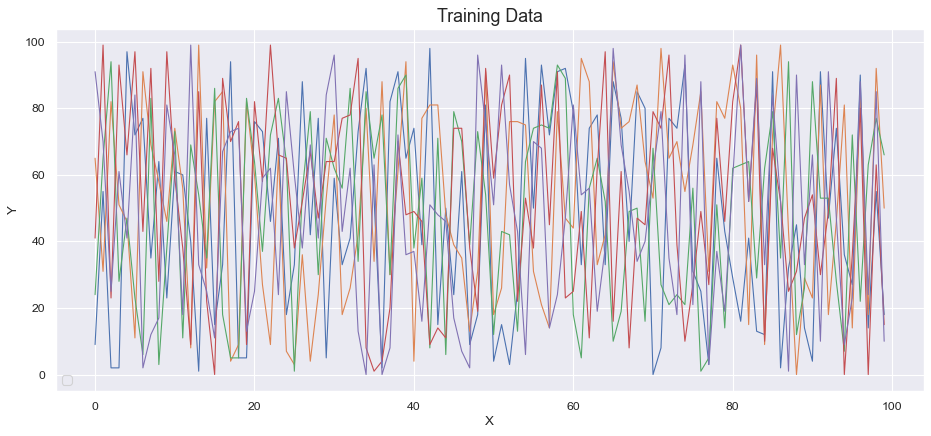

In [40]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
print(train.columns.tolist())
ax.plot(train, animated = True, linewidth=1)
ax.set_ylabel('Y')
ax.set_xlabel('X')
plt.legend(loc='lower left')
ax.set_title('Training Data', fontsize=16)
plt.show()

In [41]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [42]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (100, 1, 5)
Test data shape: (100, 1, 5)


In [43]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [44]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 5)]            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1408      
_________________________________________________________________
lstm_5 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 5)              85  

In [45]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
10/10 [==============================] - 4s 54ms/step - loss: 0.5056 - val_loss: 0.4758
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.4949 - val_loss: 0.4655
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 0.4840 - val_loss: 0.4548
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 0.4732 - val_loss: 0.4436
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 0.4620 - val_loss: 0.4317
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 0.4504 - val_loss: 0.4190
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 0.4383 - val_loss: 0.4052
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 0.4261 - val_loss: 0.3906
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 0.4133 - val_loss: 0.3753
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 0.3989 - val_loss: 0.3613
Epoch 11

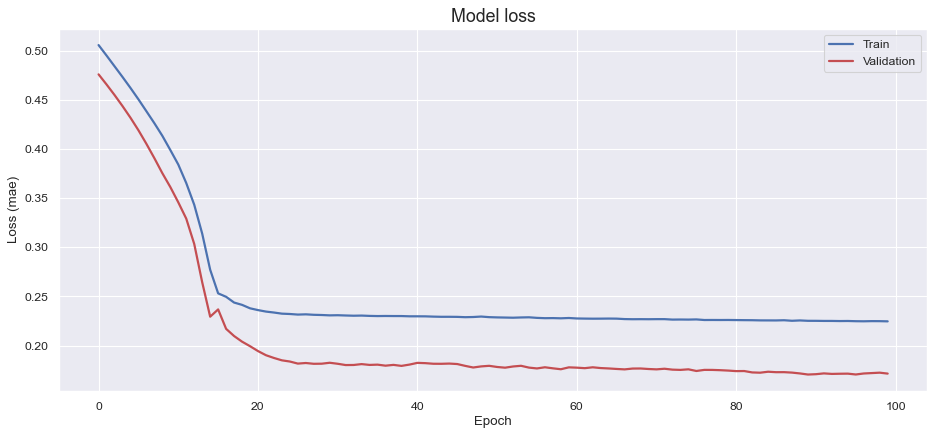

In [46]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” and that any flagged anomalies should be statistically significant above the background noise.

c:\Users\ASUS\Anaconda3\envs\ml_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.3)

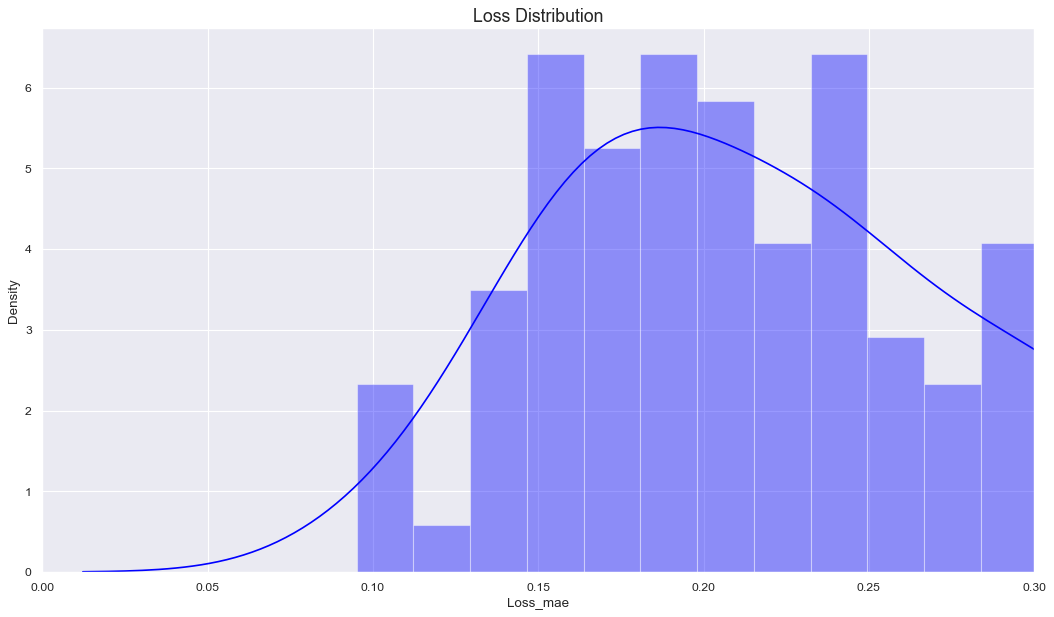

In [47]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
# X_pred = pd.DataFrame(X_pred, columns=['Voltage(V)'])
# X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue')
plt.xlim([0.0,.3])

From the above loss distribution, let's try a threshold value of 0.275 for flagging an anomaly. We can then calculate the loss in the test set to check when the output crosses the anomaly threshold.

In [48]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
# X_pred = pd.DataFrame(X_pred, columns=['Voltage(V)'])
# X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['transaction_date'] = test['transaction_date']
# scored['Voltage(V)'] = test['Voltage(V)']
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.1
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,transaction_date,Loss_mae,Threshold,Anomaly
0,0,0.267930,0.1,True
1,63,0.160072,0.1,True
2,45,0.102356,0.1,True
3,2,0.185678,0.1,True
4,35,0.146843,0.1,True


In [51]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
# X_pred_train = pd.DataFrame(X_pred_train, columns=['Voltage(V)'])
# X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['transaction_date'] = train['transaction_date']
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.1
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])
scored.to_csv('anormaly.csv')

In [58]:
anomalies = scored.loc[scored['Anomaly'] == True]

<AxesSubplot:xlabel='Date_Time'>

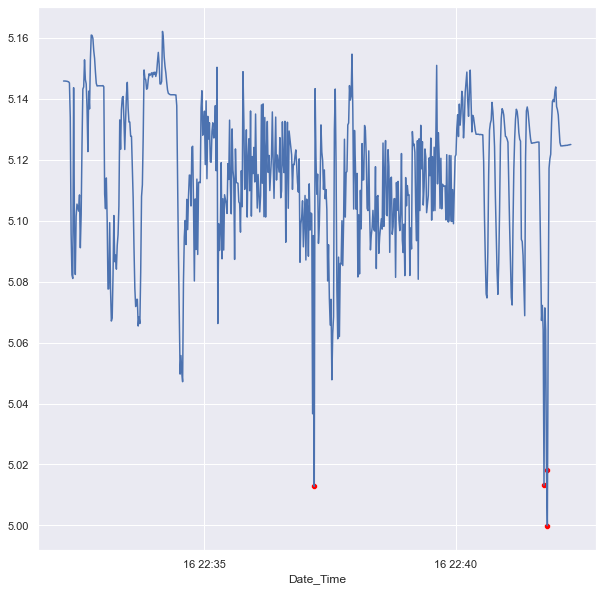

In [59]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.lineplot(x=scored['Date_Time'],y=scaler.inverse_transform(scored['Voltage(V)'].to_numpy().reshape(-1, 1)).squeeze())
sns.scatterplot(x=anomalies['Date_Time'], y=scaler.inverse_transform(anomalies['Voltage(V)'].to_numpy().reshape(-1, 1)).squeeze(), color = ['red'])

Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

In [ ]:
scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.1
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])
scored.to_csv('anormaly.csv')

sns.lineplot(x=anomaly_df['Date'],y=scaler.inverse_transform(anomaly_df['Close']))
sns.scatterplot(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), color = ['red'])

<AxesSubplot: >

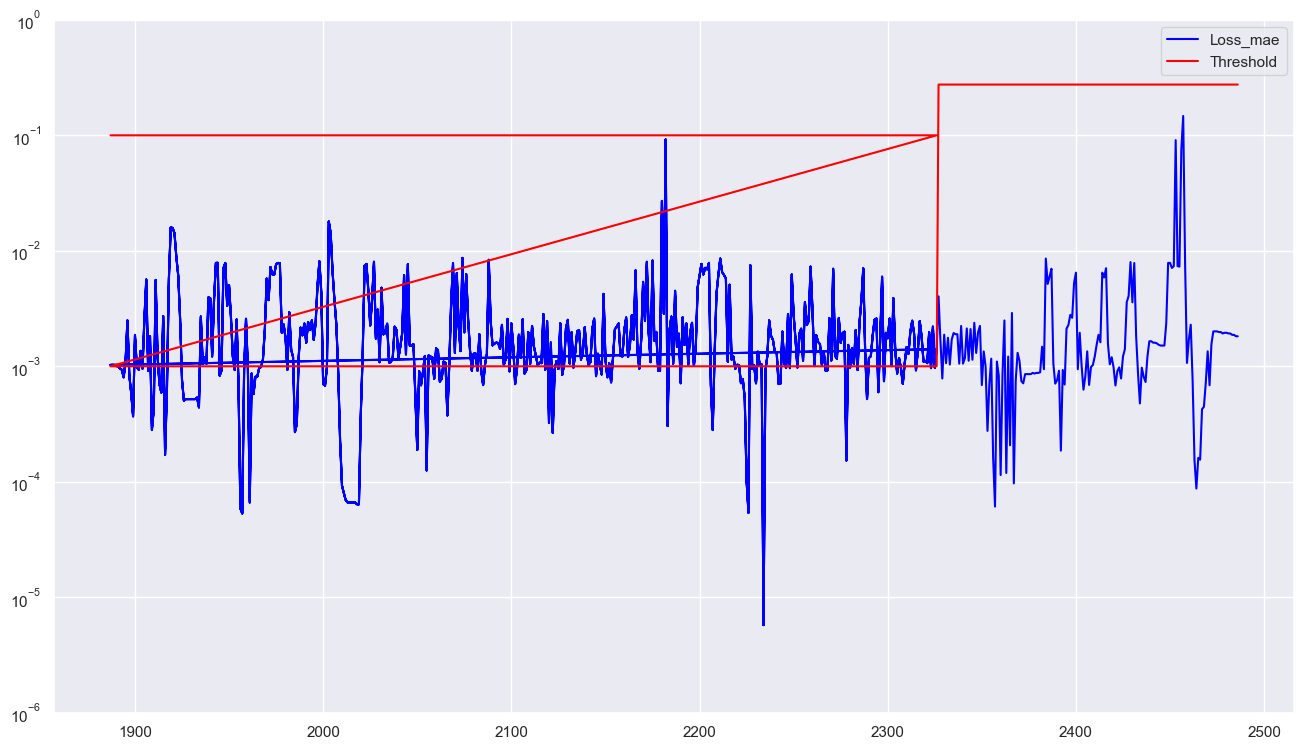

In [119]:
# plot Sensor failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-6,1e0], color=['blue','red'])

This analysis approach is able to flag the upcoming Sesor malfunction well in advance of the actual physical failure. It is important to define a suitable threshold value for flagging anomalies while avoiding too many false positives during normal operating conditions.